<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Marine-life-forecast---Data-enrichment-and-insights" data-toc-modified-id="Marine-life-forecast---Data-enrichment-and-insights-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Marine life forecast - Data enrichment and insights</a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Introduction</a></span></li></ul></li><li><span><a href="#Importing-libraries" data-toc-modified-id="Importing-libraries-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Importing libraries</a></span></li><li><span><a href="#Importing-data" data-toc-modified-id="Importing-data-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Importing data</a></span></li><li><span><a href="#Downloading-taxa-common-names" data-toc-modified-id="Downloading-taxa-common-names-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Downloading taxa common names</a></span></li><li><span><a href="#Creating-common-name-column" data-toc-modified-id="Creating-common-name-column-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Creating common name column</a></span></li><li><span><a href="#Hour-extraction" data-toc-modified-id="Hour-extraction-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Hour extraction</a></span></li><li><span><a href="#Target-selection" data-toc-modified-id="Target-selection-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Target selection</a></span></li><li><span><a href="#Aggregate-rows-by-inmersion" data-toc-modified-id="Aggregate-rows-by-inmersion-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Aggregate rows by inmersion</a></span></li><li><span><a href="#Insights" data-toc-modified-id="Insights-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Insights</a></span><ul class="toc-item"><li><span><a href="#Inmersions" data-toc-modified-id="Inmersions-9.1"><span class="toc-item-num">9.1&nbsp;&nbsp;</span>Inmersions</a></span><ul class="toc-item"><li><span><a href="#Inmersions-per-month" data-toc-modified-id="Inmersions-per-month-9.1.1"><span class="toc-item-num">9.1.1&nbsp;&nbsp;</span>Inmersions per month</a></span></li><li><span><a href="#Inmersions-per-day-of-month" data-toc-modified-id="Inmersions-per-day-of-month-9.1.2"><span class="toc-item-num">9.1.2&nbsp;&nbsp;</span>Inmersions per day of month</a></span></li><li><span><a href="#Inmersions-per-hour-of-day" data-toc-modified-id="Inmersions-per-hour-of-day-9.1.3"><span class="toc-item-num">9.1.3&nbsp;&nbsp;</span>Inmersions per hour of day</a></span></li><li><span><a href="#Maximun-depths-distribution" data-toc-modified-id="Maximun-depths-distribution-9.1.4"><span class="toc-item-num">9.1.4&nbsp;&nbsp;</span>Maximun depths distribution</a></span></li></ul></li><li><span><a href="#Targets" data-toc-modified-id="Targets-9.2"><span class="toc-item-num">9.2&nbsp;&nbsp;</span>Targets</a></span><ul class="toc-item"><li><span><a href="#Month" data-toc-modified-id="Month-9.2.1"><span class="toc-item-num">9.2.1&nbsp;&nbsp;</span>Month</a></span></li><li><span><a href="#Hour" data-toc-modified-id="Hour-9.2.2"><span class="toc-item-num">9.2.2&nbsp;&nbsp;</span>Hour</a></span></li><li><span><a href="#Depth" data-toc-modified-id="Depth-9.2.3"><span class="toc-item-num">9.2.3&nbsp;&nbsp;</span>Depth</a></span></li></ul></li></ul></li><li><span><a href="#Exporting-data" data-toc-modified-id="Exporting-data-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Exporting data</a></span></li></ul></div>

# Marine life forecast - Data enrichment and insights

## Introduction
In this notebook I'll download common names of animals, aggregate the dataset by inmersion and extract insights from it

# Importing libraries

In [105]:
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
pd.options.display.max_columns = None
style.use('ggplot')
%config Completer.use_jedi = False # Autocomplete works faster

# Importing data

In [106]:
data_folder = './data/'
input_file = 'occurrence_cleaned.txt'
df = pd.read_csv(data_folder + input_file)

# Downloading taxa common names
Using GBIF API, I'll download vernacular names of every taxon. It is done passing the of taxon to the query

First of all, I create a function to download the vernacular name of taxon key passed as parameter. Language is set in english by default, but can be modified

In [107]:
def get_common_name(taxon_key, language='en'):
    query = "https://api.gbif.org/v1/species/" + str(taxon_key) + '?language=' + language
    request = requests.get(query)
    if request.status_code != 200:
        return None
    if 'vernacularName' in (request.json().keys()):
        return request.json()['vernacularName']

Create a dataframe with distinct combinations of taxa. NaN values are filled with -1

In [108]:
df_common_names = df[['orderKey', 'familyKey', 'genusKey', 'speciesKey']].drop_duplicates().copy()

df_common_names.fillna(-1, inplace=True)

for column in df_common_names.columns:
    df_common_names[column] = df_common_names[column].astype(int)
    
df_common_names.head()

,orderKey,familyKey,genusKey,speciesKey
0,793,9413,2441864,2442225
1,793,9413,2442206,8841716
8,587,4504,2371535,2393800
9,590,4508,2334432,2334440
11,587,8597,8252335,5210114


Let's start with species. Create a dataframe with distinct species keys

In [109]:
df_species_key = df_common_names[['speciesKey']].dropna().drop_duplicates()
len(df_species_key)

3611

In [110]:
df_species_key.head()

,speciesKey
0,2442225
1,8841716
8,2393800
9,2334440
11,5210114


Downloading common names of species

In [111]:
df_species_key['common_name_species'] = df_species_key['speciesKey'].apply(get_common_name)

There are some rows that have an error as response. For those values None is assign

In [112]:
df_species_key.loc[df_species_key['common_name_species'] == 'Error', 'common_name_species'] = None
df_species_key[df_species_key['common_name_species'].isna()].head()

,speciesKey,common_name_species
12,2289709,None
31,4359792,None
60,-1,None
93,5973132,None
135,9809158,None


Now, the same with genus

In [113]:
df_genus_key = df_common_names[['genusKey']].dropna().drop_duplicates()
len(df_genus_key)

1692

In [114]:
df_genus_key['common_name_genus'] = df_genus_key['genusKey'].apply(get_common_name)

In [115]:
df_genus_key.loc[df_genus_key['common_name_genus'] == 'Error', 'common_name_genus'] = None
df_genus_key[df_genus_key['common_name_genus'].isna()].head()

,genusKey,common_name_genus
11,8252335,None
12,2289226,None
13,9720698,None
14,2383304,None
19,2388808,None


Turn for family

In [116]:
df_family_key = df_common_names[['familyKey']].dropna().drop_duplicates()
len(df_family_key)

636

In [117]:
df_family_key['common_name_family'] = df_family_key['familyKey'].apply(get_common_name)

In [118]:
df_family_key.loc[df_family_key['common_name_family'] == 'Error', 'common_name_family'] = None
df_family_key[df_family_key['common_name_family'].isna()].head()

,familyKey,common_name_family
12,6835,None
25,9220,None
31,6560,None
52,6839,None
54,6825,None


And the last one, order

In [119]:
df_order_key = df_common_names[['orderKey']].dropna().drop_duplicates()
len(df_order_key)

169

In [120]:
df_order_key['common_name_order'] = df_order_key['orderKey'].apply(get_common_name)

In [121]:
df_order_key.loc[df_order_key['common_name_order'] == 'Error', 'common_name_order'] = None
df_order_key[df_order_key['common_name_order'].isna()].head()

,orderKey,common_name_order
13,773,None
23,1080,None
46,810,None
54,8403901,None
191,9505681,None


# Creating common name column
Create an unique column with most known common name

Merge all dataframes that contain common names with the dataframe that contains keys of all taxa

In [122]:
df_common_names = df_common_names.merge(df_order_key, on='orderKey', how='left')

In [123]:
df_common_names = df_common_names.merge(df_family_key, on='familyKey', how='left')

In [124]:
df_common_names = df_common_names.merge(df_genus_key, on='genusKey', how='left')

In [125]:
df_common_names = df_common_names.merge(df_species_key, on='speciesKey', how='left')

In [126]:
df_common_names.head()

,orderKey,familyKey,genusKey,speciesKey,common_name_order,common_name_family,common_name_genus,common_name_species
0,793,9413,2441864,2442225,turtle,Sea Turtles,green sea turtle,Green turtle
1,793,9413,2442206,8841716,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle
2,587,4504,2371535,2393800,perch-like fish,parrotfishes,parrotfishes,Palenose parrotfish
3,590,4508,2334432,2334440,mail-cheeked fishes,firefishes,butterfly-cods,clearfin turkeyfish
4,587,8597,8252335,5210114,perch-like fish,groupers,None,bluedotted coraltrout


Now create the column common name with the values of common name family column. If there are NaN values, then common name order will be used, then common name genus and if still there are NaN, then common name species will be used

In [127]:
df_common_names['common_name'] = df_common_names['common_name_family']
df_common_names['common_name'].isna().sum()

737

In [128]:
df_common_names.loc[df_common_names['common_name'].isna(), 'common_name'] = df_common_names.loc[df_common_names['common_name'].isna()]['common_name_order']
df_common_names['common_name'].isna().sum()

256

In [129]:
df_common_names.loc[df_common_names['common_name'].isna(), 'common_name'] = df_common_names.loc[df_common_names['common_name'].isna()]['common_name_genus']
df_common_names['common_name'].isna().sum()

244

In [130]:
df_common_names.loc[df_common_names['common_name'].isna(), 'common_name'] = df_common_names.loc[df_common_names['common_name'].isna()]['common_name_species']
df_common_names['common_name'].isna().sum()

94

Drop NaN values and capitalize names

In [131]:
df_common_names.dropna(subset=['common_name'], inplace=True)
df_common_names['common_name'] = df_common_names['common_name'].str.capitalize()

Assign common name to each observation of the original dataset

In [132]:
df = df.merge(df_common_names, how='left', on=['orderKey','familyKey','genusKey','speciesKey'])
df['common_name'].isna().sum()

1548

Null values will remain in the dataset

In [133]:
df.head()

,eventDate,month,day,waterBody,countryCode,locality,dive_id,decimalLatitude,decimalLongitude,depth,orderKey,familyKey,genusKey,speciesKey,common_name_order,common_name_family,common_name_genus,common_name_species,common_name
0,2019-05-29T10:06:00,5,29,South Pacific Ocean,WS,Taliga,2492,-13.9387,-171.553,13.50,793.0,9413.0,2441864.0,2442225.0,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles
1,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,793.0,9413.0,2442206.0,8841716.0,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles
2,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,793.0,9413.0,2441864.0,2442225.0,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles
3,2019-05-30T12:04:00,5,30,South Pacific Ocean,WS,Cowabunga,2495,-13.9387,-171.553,9.75,793.0,9413.0,2441864.0,2442225.0,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles
4,2019-05-30T10:02:00,5,30,South Pacific Ocean,WS,Cowabunga,2494,-13.9387,-171.553,10.50,793.0,9413.0,2442206.0,8841716.0,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles


# Hour extraction
In this step I extract the hour from the eventDate column

In [134]:
df['hour'] = df['eventDate'].str.split('T')[:].str[1].str.split(':').str[0].astype('int')
df.head()

,eventDate,month,day,waterBody,countryCode,locality,dive_id,decimalLatitude,decimalLongitude,depth,orderKey,familyKey,genusKey,speciesKey,common_name_order,common_name_family,common_name_genus,common_name_species,common_name,hour
0,2019-05-29T10:06:00,5,29,South Pacific Ocean,WS,Taliga,2492,-13.9387,-171.553,13.50,793.0,9413.0,2441864.0,2442225.0,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,10
1,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,793.0,9413.0,2442206.0,8841716.0,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,12
2,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,793.0,9413.0,2441864.0,2442225.0,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12
3,2019-05-30T12:04:00,5,30,South Pacific Ocean,WS,Cowabunga,2495,-13.9387,-171.553,9.75,793.0,9413.0,2441864.0,2442225.0,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12
4,2019-05-30T10:02:00,5,30,South Pacific Ocean,WS,Cowabunga,2494,-13.9387,-171.553,10.50,793.0,9413.0,2442206.0,8841716.0,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,10


Delete the columns that contain taxa keys

In [135]:
df.drop(['orderKey', 'familyKey', 'genusKey', 'speciesKey'], axis=1, inplace=True)

# Target selection
Now it is time to select the target. It will be the top five seen animals

In [136]:
df_agg = df.groupby('common_name').count().sort_values(by='eventDate', ascending=False)[['eventDate']]
targets = df_agg[:5].reset_index()['common_name']
targets

0      Moray eels
1      Firefishes
2    Damselfishes
3     Sea turtles
4        Groupers
Name: common_name, dtype: object

I'll create a function that checks if common the column contains the common name, then use this function to check if common name is in the top five seen animals and create a binary column that indicates if the animal has been seen

In [137]:
def assign_targets(column, common_name):
    return int(column == common_name)

In [138]:
for target in targets:
    df['{}'.format(target)] = df.apply(lambda row: assign_targets(row['common_name'], target), axis=1)

df.head()

,eventDate,month,day,waterBody,countryCode,locality,dive_id,decimalLatitude,decimalLongitude,depth,common_name_order,common_name_family,common_name_genus,common_name_species,common_name,hour,Moray eels,Firefishes,Damselfishes,Sea turtles,Groupers
0,2019-05-29T10:06:00,5,29,South Pacific Ocean,WS,Taliga,2492,-13.9387,-171.553,13.50,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,10,0,0,0,1,0
1,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,12,0,0,0,1,0
2,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12,0,0,0,1,0
3,2019-05-30T12:04:00,5,30,South Pacific Ocean,WS,Cowabunga,2495,-13.9387,-171.553,9.75,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12,0,0,0,1,0
4,2019-05-30T10:02:00,5,30,South Pacific Ocean,WS,Cowabunga,2494,-13.9387,-171.553,10.50,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,10,0,0,0,1,0


# Aggregate rows by inmersion
The objective of this work is to predict animals seen by inmersion, but the dataset contains all observations seen by inmersion. Next step is to aggregate rows by inmersion, and, set 1 if the animal has been seen at least one time

In [139]:
df_count_target = df.groupby('dive_id')[targets].sum().reset_index()

for target in targets:
    df_count_target.loc[df_count_target[target] >= 1, target] = 1

df_unique = df.drop_duplicates(subset='dive_id')
df_unique.drop(targets, axis=1, inplace=True)

df_aggregated = df_unique.merge(df_count_target, how='left', on='dive_id')

df_aggregated.shape

/home/davidgp/anaconda3/envs/malif2/lib/python3.8/site-packages/pandas/core/frame.py:4305: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


(11808, 21)

In [140]:
df_aggregated.head()

,eventDate,month,day,waterBody,countryCode,locality,dive_id,decimalLatitude,decimalLongitude,depth,common_name_order,common_name_family,common_name_genus,common_name_species,common_name,hour,Moray eels,Firefishes,Damselfishes,Sea turtles,Groupers
0,2019-05-29T10:06:00,5,29,South Pacific Ocean,WS,Taliga,2492,-13.9387,-171.553,13.50,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,10,0,0,0,1,0
1,2019-05-29T12:15:00,5,29,South Pacific Ocean,WS,Cowabunga,2493,-13.9387,-171.553,10.20,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,12,0,0,0,1,0
2,2019-05-30T12:04:00,5,30,South Pacific Ocean,WS,Cowabunga,2495,-13.9387,-171.553,9.75,turtle,Sea Turtles,green sea turtle,Green turtle,Sea turtles,12,0,0,0,1,0
3,2019-05-30T10:02:00,5,30,South Pacific Ocean,WS,Cowabunga,2494,-13.9387,-171.553,10.50,turtle,Sea Turtles,Hawksbill Sea Turtles,Hawksbill turtle,Sea turtles,10,0,0,0,1,0
4,2015-07-22T18:56:00,7,22,Hidden Lake,EG,Sunrise Grand Select Montemare Resort House Reef,7393,53.8635,-166.049,10.00,perch-like fish,parrotfishes,parrotfishes,Palenose parrotfish,Parrotfishes,18,0,1,0,0,0


# Insights

## Inmersions

### Inmersions per month

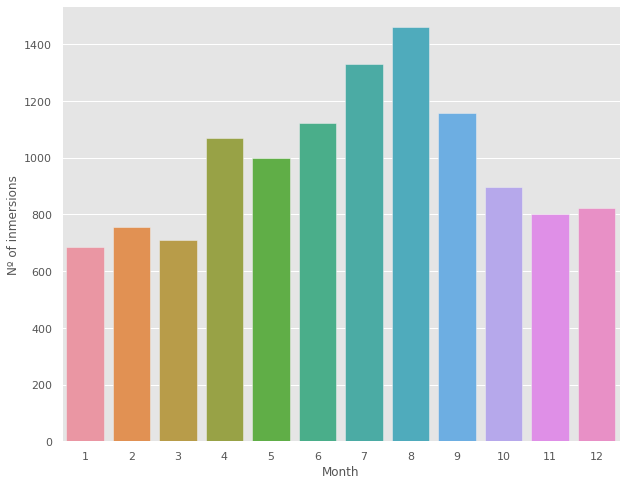

In [141]:
plt.figure(figsize=(10,8))
data = df_aggregated.groupby('month').count()['dive_id']
ax = sns.barplot(x=data.index, y=data)
ax.set(xlabel='Month', ylabel='Nº of inmersions')
plt.show()

Most of the inmersions are between june and september, usually summer vacations in the North Hemisphere

### Inmersions per day of month

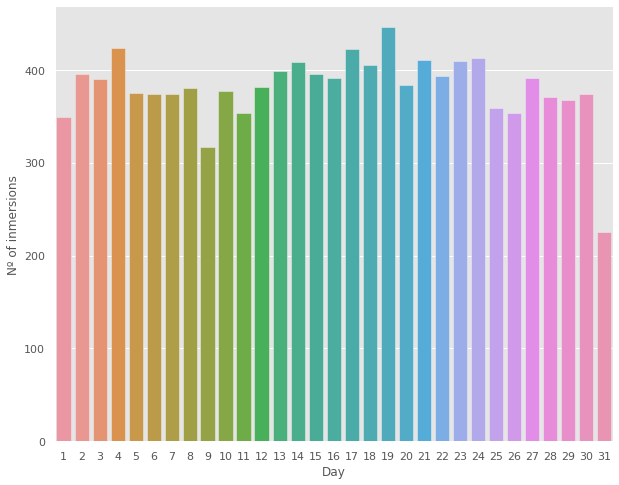

In [142]:
plt.figure(figsize=(10,8))
data = df_aggregated.groupby('day').count()['dive_id']
ax = sns.barplot(x=data.index, y=data)
ax.set(xlabel='Day', ylabel='Nº of inmersions')
plt.show()

Inmersions per day have an uniform distribution

### Inmersions per hour of day

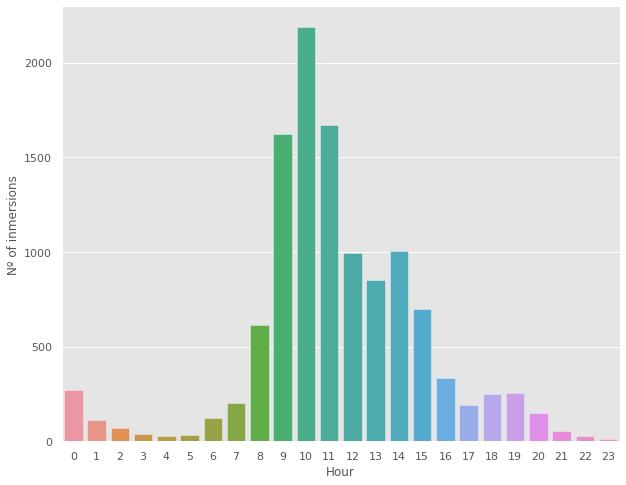

In [143]:
plt.figure(figsize=(10,8))
data = df_aggregated.groupby('hour').count()['dive_id']
ax = sns.barplot(x=data.index, y=data)
ax.set(xlabel='Hour', ylabel='Nº of inmersions')
plt.show()

Most of the inmersions occur before lunch time, between 9 and 12

### Maximun depths distribution

Using paper to select best bins number (R(n^(1/3))/(3.49σ)):
- R is the range of data (R = 40-0= 40),
- n is the number of samples,
- σ is your standard deviation.  
https://academic.oup.com/biomet/article-abstract/66/3/605/232642

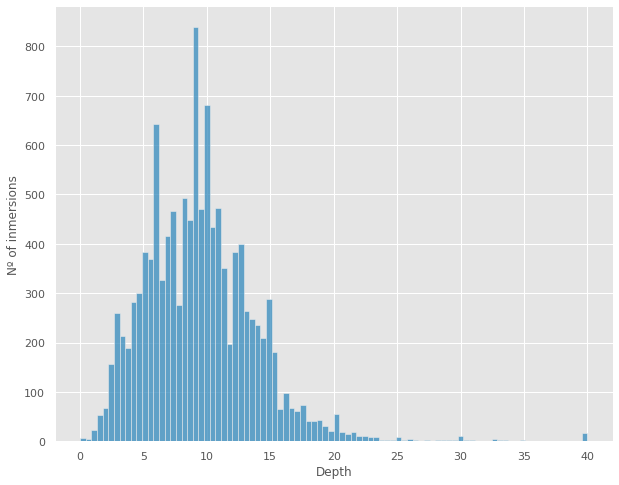

In [174]:
bins = int(40*(len(df)**(1/3))/(3.49*np.std(df['depth'])))

plt.figure(figsize=(10,8))
ax = sns.histplot(df_aggregated['depth'], bins=bins)
ax.set(xlabel='Depth', ylabel='Nº of inmersions')
plt.show()

Apparently, inmersions between 5 and 15 meters are the more common

## Targets

In [160]:
df_targets = df[df['common_name'].isin(targets)].copy()

### Month

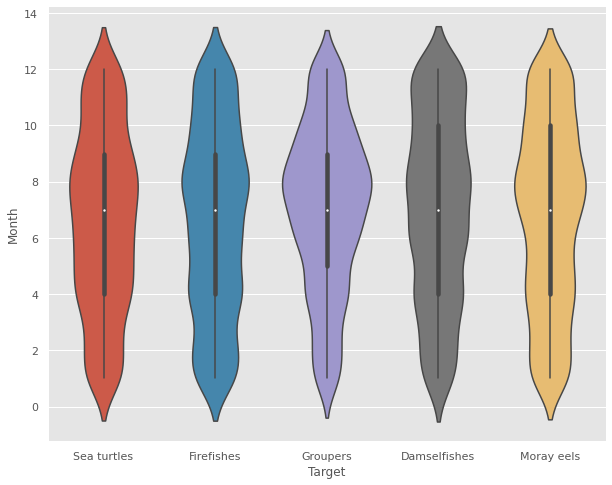

In [171]:
plt.figure(figsize=(10,8))
ax = sns.violinplot(data=df_targets, x='common_name', y='month')
ax.set(xlabel='Target', ylabel='Month')
plt.show()

Like inmersions per month, the targets are more common in the summer, between june and september. Just gruopers seem to apper more in august

### Hour

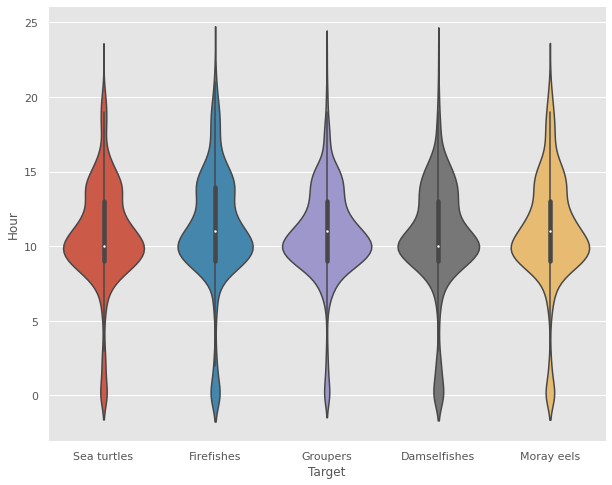

In [175]:
plt.figure(figsize=(10,8))
ax = sns.violinplot(data=df_targets, x='common_name', y='hour')
ax.set(xlabel='Target', ylabel='Hour')
plt.show()

The most common hours are in the range of 9 to 12

### Depth

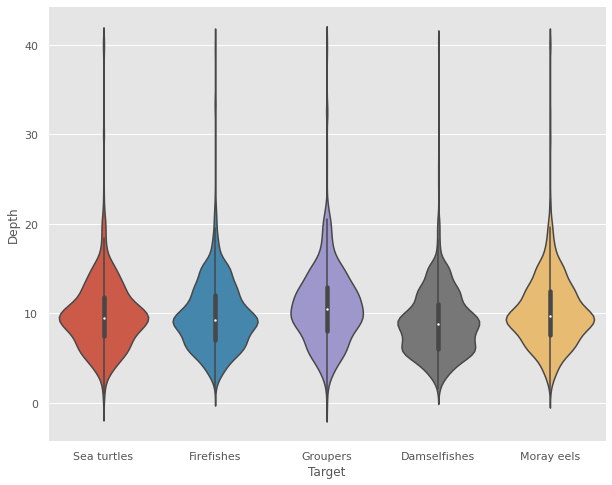

In [170]:
plt.figure(figsize=(10,8))
ax = sns.violinplot(data=df_targets, x='common_name', y='depth')
ax.set(xlabel='Target', ylabel='Depth')
plt.show()

The targets are most seen between 5 and 15 meters, just like the distributions of inmersions

# Exporting data

In [40]:
output_file = 'occurrence_aggregated.txt'
df_aggregated.to_csv(data_folder + output_file, index=False)